# An attempt at making some functions for feature generation

In [26]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 18 columns):
 #   Column                                  Non-Null Count   Dtype         
---  ------                                  --------------   -----         
 0   Unnamed: 0                              100000 non-null  int64         
 1   Time                                    100000 non-null  datetime64[ns]
 2   Date                                    100000 non-null  object        
 3   Exchange                                100000 non-null  object        
 4   Symbol                                  100000 non-null  object        
 5   Trade_Volume                            100000 non-null  int64         
 6   Trade_Price                             100000 non-null  float64       
 7   Sale_Condition                          100000 non-null  object        
 8   Source_of_Trade                         100000 non-null  object        
 9   Trade_Stop_Stock_Indicator            

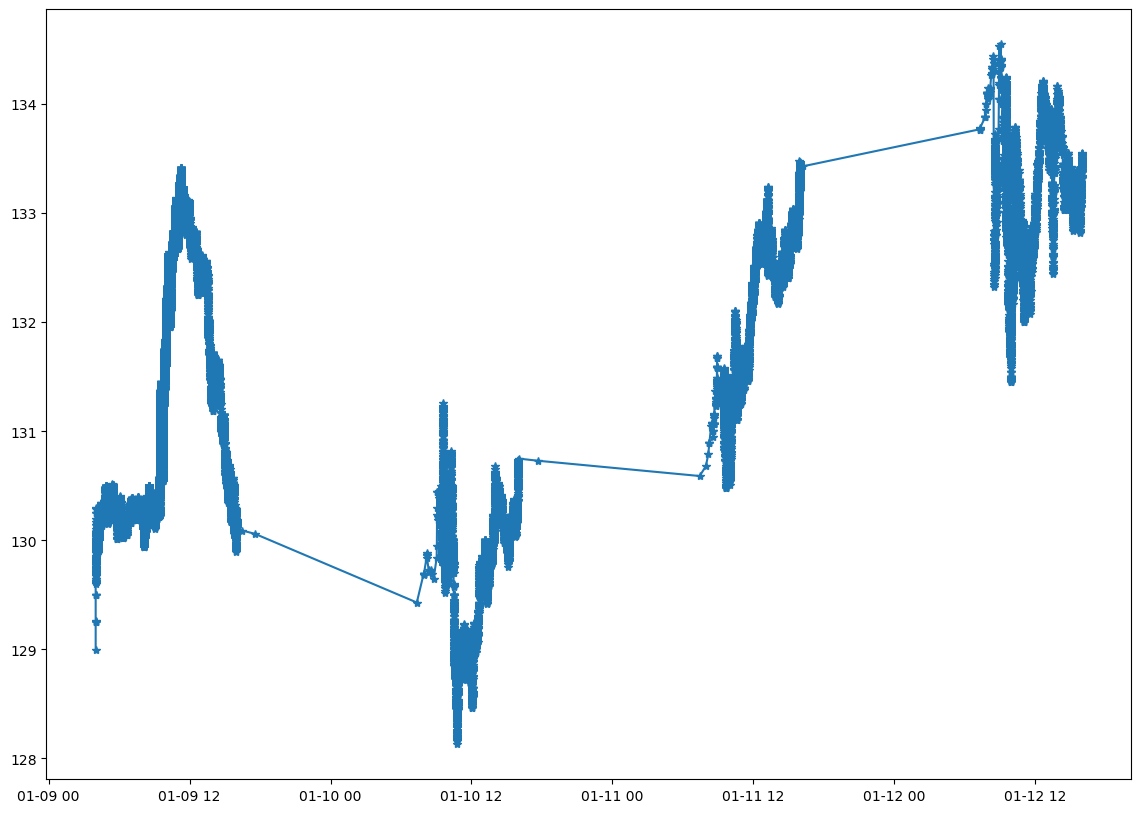

In [27]:
data=pd.read_csv('data/trades_AAPL_20230109-20230113.csv.gz', compression='gzip')

data['Time']=pd.to_datetime(data['Time'])

print(data.info())
fig,ax=plt.subplots(figsize=(14,10))
# ax.plot(data['Time'],data['Trade_Price'],marker='*')
ax.plot(data['Time'],data['Trade_Price'],marker='*')


In [28]:
selected_columns = ["Time", "Date", "Symbol", "Trade_Price", "Trade_Volume", "YearMonth"]
filtered_data = data[selected_columns]

print(filtered_data.info())
print(filtered_data.head())
print(filtered_data.tail())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Time          100000 non-null  datetime64[ns]
 1   Date          100000 non-null  object        
 2   Symbol        100000 non-null  object        
 3   Trade_Price   100000 non-null  float64       
 4   Trade_Volume  100000 non-null  int64         
 5   YearMonth     100000 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 4.6+ MB
None
                        Time        Date Symbol  Trade_Price  Trade_Volume  \
0 2023-01-09 04:00:00.006721  2023-01-09   AAPL       128.99            25   
1 2023-01-09 04:00:00.007140  2023-01-09   AAPL       129.65             8   
2 2023-01-09 04:00:00.007214  2023-01-09   AAPL       129.25            10   
3 2023-01-09 04:00:00.007637  2023-01-09   AAPL       129.25            18   
4 2023-

In [ ]:
# Assuming 'filtered_data' is your DataFrame with the raw high-frequency trading data.

# Function to find and return duplicate DateTime entries in the data
def find_duplicates(df):
    """
    Identify and return a DataFrame containing duplicate entries based on DateTime.

    :param df: DataFrame with high-frequency trading data.
    :return: DataFrame with duplicate DateTime entries.
    """
    # Convert 'Time' and 'Date' to a single datetime column
    # df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])
    
    # Check for duplicates in the DateTime column
    duplicate_rows = df[df.duplicated('Time', keep=False)]
    
    return duplicate_rows

# Call the function to find duplicates
duplicate_entries = find_duplicates(filtered_data)

print(duplicate_entries.head())

In [29]:
# Assuming 'filtered_data' is your DataFrame with the raw high-frequency trading data.

# Function to resample DataFrame to 1-minute intervals
def resample_data(df, resample_rate='1T', forward_fill=True):
    """
    Resample the time series data to a specified rate.

    :param df: DataFrame with high-frequency trading data.
    :param resample_rate: The frequency rate to resample the DataFrame. Default is '1T' (1 minute).
    :return: Resampled DataFrame with the original columns.
    """
    # Make a copy of the DataFrame to avoid SettingWithCopyWarning
    df_copy = df.copy()
    
    # Convert 'Time' and 'Date' to a single datetime column and set as index
    df_copy.set_index('Time', inplace=True)
    
    # Sort the index just in case it's not sorted
    df_copy.sort_index(inplace=True)
    
    # Drop duplicate indices
    df_copy = df_copy[~df_copy.index.duplicated(keep='first')]
    
    # Define the aggregation dictionary for resampling
    aggregation = {
        'Trade_Price': 'last',
        'Trade_Volume': 'sum'  # Assuming you want to sum the volumes within the interval
    }
    
    # Resample the DataFrame
    resampled_df = df_copy.resample(resample_rate).agg(aggregation)
    
    # Forward fill the Trade_Price to handle NaN values if there are no trades in the interval
    if forward_fill: resampled_df['Trade_Price'].ffill(inplace=True)
    
    # Merge the resampled data back with the original dataframe to preserve non-numeric columns
    # This aligns the non-numeric data with the resampled numeric data
    df_non_numeric = df_copy[['Date', 'Symbol', 'YearMonth']].resample(resample_rate).ffill()
    full_resampled_df = pd.concat([df_non_numeric, resampled_df], axis=1)
    
    return full_resampled_df

# Call the function with the dataframe and the resampling rate
# Example: resampled_dataframe = resample_data(filtered_data, '1T')


In [30]:
resampled_dataframe = resample_data(filtered_data, '1T')
print(resampled_dataframe.info())
print(resampled_dataframe.head())
print(resampled_dataframe.tail())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5040 entries, 2023-01-09 04:00:00 to 2023-01-12 15:59:00
Freq: T
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          5039 non-null   object 
 1   Symbol        5039 non-null   object 
 2   YearMonth     5039 non-null   float64
 3   Trade_Price   5040 non-null   float64
 4   Trade_Volume  5040 non-null   int64  
dtypes: float64(2), int64(1), object(2)
memory usage: 236.2+ KB
None
                           Date Symbol  YearMonth  Trade_Price  Trade_Volume
Time                                                                        
2023-01-09 04:00:00         NaN    NaN        NaN       129.71          2053
2023-01-09 04:01:00  2023-01-09   AAPL   202301.0       129.76          6206
2023-01-09 04:02:00  2023-01-09   AAPL   202301.0       130.00          1997
2023-01-09 04:03:00  2023-01-09   AAPL   202301.0       129.99          2994
2023-01-09 04:04:0

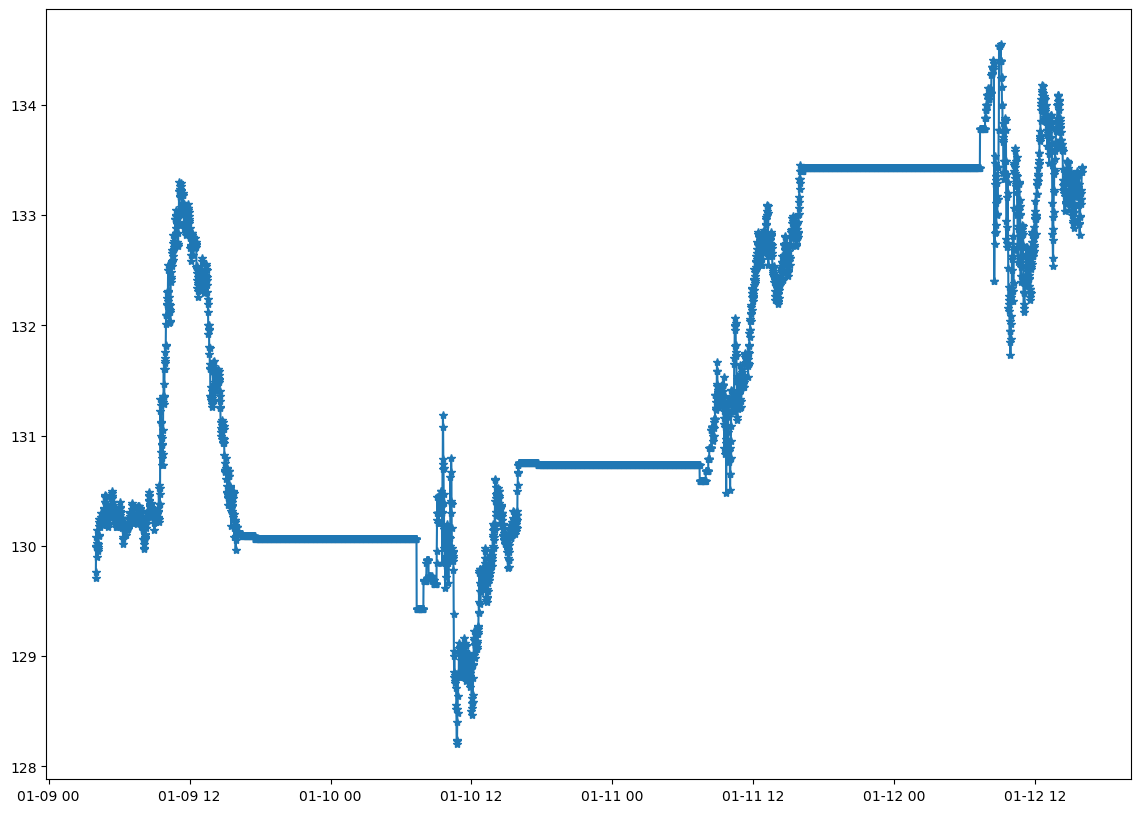

In [31]:
fig,ax=plt.subplots(figsize=(14,10))
ax.plot(resampled_dataframe.index,resampled_dataframe['Trade_Price'],marker='*')

# print(resampled_dataframe.iloc[700:1000][["Trade_Price"]])


In [30]:
def filter_trading_hours(df):
    """
    Filters the DataFrame to only include rows that fall within standard trading hours.
    Assumes that the index is a datetime index and that the data is already at 1-minute intervals.
    
    Standard trading hours are assumed to be 9:30 AM to 4:00 PM.

    Args:
    df (pd.DataFrame): DataFrame with a datetime index.

    Returns:
    pd.DataFrame: DataFrame filtered to only include trading hours.
    """
    # Define the start and end times for standard trading hours
    market_open = pd.to_datetime('09:30:00').time()
    market_close = pd.to_datetime('16:00:00').time()
    
    # Filter the DataFrame to only include times within trading hours
    df_during_trading_hours = df.between_time(market_open, market_close)
    
    return df_during_trading_hours

In [31]:
# filtered_dataframe = filter_trading_hours(resampled_dataframe)

# print(filtered_dataframe.head())
# print(filtered_dataframe.info())
# print(filtered_dataframe.tail())

# fig,ax=plt.subplots(figsize=(14,10))
# ax.plot(filtered_dataframe.index,filtered_dataframe['Trade_Price'],marker='*')

                           Date Symbol  YearMonth  Trade_Price  Trade_Volume
Time                                                                        
2023-01-09 09:30:00  2023-01-09   AAPL   202301.0      131.330       1815653
2023-01-09 09:31:00  2023-01-09   AAPL   202301.0      131.220        139577
2023-01-09 09:32:00  2023-01-09   AAPL   202301.0      131.280        150694
2023-01-09 09:33:00  2023-01-09   AAPL   202301.0      131.115         73962
2023-01-09 09:34:00  2023-01-09   AAPL   202301.0      131.120        102351
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1563 entries, 2023-01-09 09:30:00 to 2023-01-12 15:59:00
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          1563 non-null   object 
 1   Symbol        1563 non-null   object 
 2   YearMonth     1563 non-null   float64
 3   Trade_Price   1563 non-null   float64
 4   Trade_Volume  1563 non-null   int64  
dtypes: float64(2)

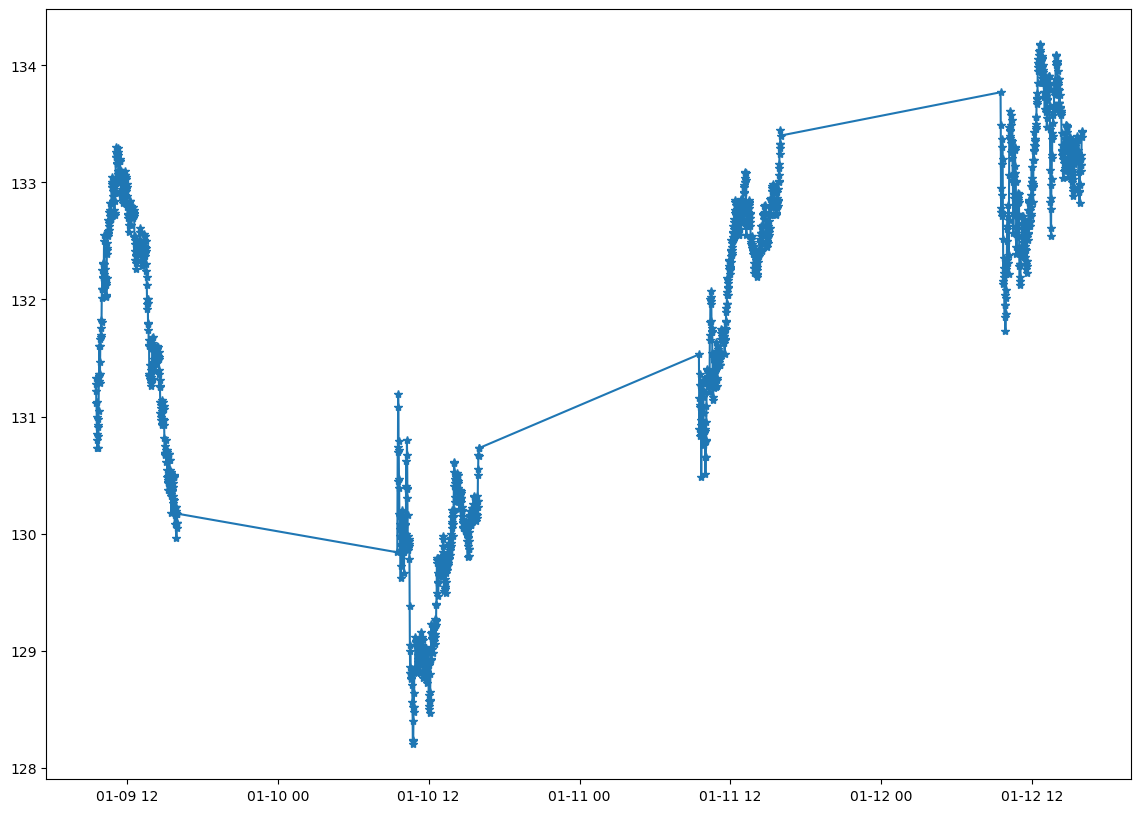

In [32]:
from typing import Dict, List, Tuple

VOL_LOOKBACK = 60  # for ex-ante volatility (in minutes)
VOL_TARGET = 0.15  # 15% volatility target

def calc_returns(srs: pd.Series, minute_offset: int = 1) -> pd.Series:
    """for each element of a pandas time-series srs,
    calculates the returns over the past number of minutes
    specified by offset

    Args:
        srs (pd.Series): time-series of prices
        minute_offset (int, optional): number of minutes to calculate returns over. Defaults to 1.

    Returns:
        pd.Series: series of returns
    """
    returns = srs / srs.shift(minute_offset) - 1.0
    return returns

# calculate volatility over 60 minute windows.
def calc_minute_vol(minute_returns, lookback_minutes=60):
    return (
        minute_returns.ewm(span=lookback_minutes, min_periods=lookback_minutes)
        .std()
        .fillna(method="bfill")
    )

def calc_normalised_returns(minute_offset, df_asset):
        return (
            calc_returns(df_asset["srs"], minute_offset)
            / df_asset["daily_vol"]
            / np.sqrt(minute_offset)
        )

# def calc_vol_scaled_returns(daily_returns, daily_vol=pd.Series(None)):
#     """calculates volatility scaled returns for annualised VOL_TARGET of 15%
#     with input of pandas series daily_returns"""
#     if not len(daily_vol):
#         daily_vol = calc_minute_vol(daily_returns)
#     annualised_vol = daily_vol * np.sqrt(252)  # annualised
#     return daily_returns * VOL_TARGET / annualised_vol.shift(1)

class MACDStrategy:
    def __init__(self, trend_combinations: List[Tuple[float, float]] = None):
        """Used to calculated the combined MACD signal for a multiple short/signal combinations,
        as described in https://arxiv.org/pdf/1904.04912.pdf

        Args:
            trend_combinations (List[Tuple[float, float]], optional): short/long trend combinations. Defaults to None.
        """
        if trend_combinations is None:
            self.trend_combinations = [(8, 24), (16, 48), (32, 96)]
        else:
            self.trend_combinations = trend_combinations

    @staticmethod
    def calc_signal(srs: pd.Series, short_timescale: int, long_timescale: int) -> float:
        """Calculate MACD signal for a signal short/long timescale combination

        Args:
            srs ([type]): series of prices
            short_timescale ([type]): short timescale
            long_timescale ([type]): long timescale

        Returns:
            float: MACD signal
        """

        def _calc_halflife(timescale):
            return np.log(0.5) / np.log(1 - 1 / timescale)

        macd = (
            srs.ewm(halflife=_calc_halflife(short_timescale)).mean()
            - srs.ewm(halflife=_calc_halflife(long_timescale)).mean()
        )
        q = macd / srs.rolling(63).std().fillna(method="bfill")
        return q / q.rolling(252).std().fillna(method="bfill")

    @staticmethod
    def scale_signal(y):
        return y * np.exp(-(y ** 2) / 4) / 0.89

    def calc_combined_signal(self, srs: pd.Series) -> float:
        """Combined MACD signal

        Args:
            srs (pd.Series): series of prices

        Returns:
            float: MACD combined signal
        """
        return np.sum(
            [self.calc_signal(srs, S, L) for S, L in self.trend_combinations]
        ) / len(self.trend_combinations)


In [33]:
test_features = resampled_dataframe.copy()

In [34]:
VOL_THRESHOLD = 5  # multiple to winsorise by
HALFLIFE_WINSORISE = 390 #number of minutes in a trading day. Not sure if this is an appropriate value or what

# winsorize using rolling 5X standard deviations to remove outliers
resampled_dataframe["srs"] = resampled_dataframe["Trade_Price"]
ewm = resampled_dataframe["srs"].ewm(halflife=HALFLIFE_WINSORISE)
means = ewm.mean()
stds = ewm.std()
resampled_dataframe["srs"] = np.minimum(resampled_dataframe["srs"], means + VOL_THRESHOLD * stds)
resampled_dataframe["srs"] = np.maximum(resampled_dataframe["srs"], means - VOL_THRESHOLD * stds)

resampled_dataframe["minute_returns"] = calc_returns(resampled_dataframe["srs"])
resampled_dataframe["minute_vol"] = calc_minute_vol(resampled_dataframe["minute_returns"])

# vol scaling and shift to be next day returns
# resampled_dataframe["target_returns"] = calc_vol_scaled_returns(
#     resampled_dataframe["daily_returns"], resampled_dataframe["daily_vol"]
# ).shift(-1)

def calc_normalised_returns(minute_offset):
    return (
        calc_returns(resampled_dataframe["srs"], minute_offset)
        / resampled_dataframe["minute_vol"]
        / np.sqrt(minute_offset)
    )

# intervals_in_minutes = [20, 60, 120, 180, 240]  # 20 minutes, 1 hour, 2 hours, 3 hours, 4 hours

resampled_dataframe["norm_min_return"] = calc_normalised_returns(1)
resampled_dataframe["norm_20min_return"] = calc_normalised_returns(20)
resampled_dataframe["norm_60min_return"] = calc_normalised_returns(60)
resampled_dataframe["norm_120min_return"] = calc_normalised_returns(120)
resampled_dataframe["norm_180min_return"] = calc_normalised_returns(180)

# calculating MACDs with this method not currently working. Left in for analysis purposes
trend_combinations = [(8, 24), (16, 48), (32, 96)]
for short_window, long_window in trend_combinations:
    resampled_dataframe[f"macd_{short_window}_{long_window}"] = MACDStrategy.calc_signal(
        resampled_dataframe["srs"], short_window, long_window
    )

feature_dataframe = resampled_dataframe.dropna(inplace= False)

C:\Users\kxfor\AppData\Local\Temp\ipykernel_10608\3218290722.py:24: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  minute_returns.ewm(span=lookback_minutes, min_periods=lookback_minutes)
C:\Users\kxfor\AppData\Local\Temp\ipykernel_10608\3218290722.py:77: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  q = macd / srs.rolling(63).std().fillna(method="bfill")
C:\Users\kxfor\AppData\Local\Temp\ipykernel_10608\3218290722.py:78: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return q / q.rolling(252).std().fillna(method="bfill")
C:\Users\kxfor\AppData\Local\Temp\ipykernel_10608\3218290722.py:77: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  q = m

In [35]:
print(feature_dataframe.info())
print(feature_dataframe.head())
print(feature_dataframe.tail())

feature_dataframe.describe()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4859 entries, 2023-01-09 07:01:00 to 2023-01-12 15:59:00
Freq: T
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Date                4859 non-null   object 
 1   Symbol              4859 non-null   object 
 2   YearMonth           4859 non-null   float64
 3   Trade_Price         4859 non-null   float64
 4   Trade_Volume        4859 non-null   int64  
 5   srs                 4859 non-null   float64
 6   minute_returns      4859 non-null   float64
 7   minute_vol          4859 non-null   float64
 8   norm_min_return     4859 non-null   float64
 9   norm_20min_return   4859 non-null   float64
 10  norm_60min_return   4859 non-null   float64
 11  norm_120min_return  4859 non-null   float64
 12  norm_180min_return  4859 non-null   float64
 13  macd_8_24           4859 non-null   float64
 14  macd_16_48          4859 non-null   float64
 15  macd_32_96 

c:\Users\kxfor\anaconda3\envs\query_user_test\lib\site-packages\numpy\core\_methods.py:49: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
c:\Users\kxfor\anaconda3\envs\query_user_test\lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
c:\Users\kxfor\anaconda3\envs\query_user_test\lib\site-packages\numpy\core\_methods.py:49: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
c:\Users\kxfor\anaconda3\envs\query_user_test\lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
c:\Users\kxfor\anaconda3\envs\query_user_test\lib\site-packages\numpy\core\_methods.py:49: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
c:\Users\kxfor\anacon

,YearMonth,Trade_Price,Trade_Volume,srs,minute_returns,minute_vol,norm_min_return,norm_20min_return,norm_60min_return,norm_120min_return,norm_180min_return,macd_8_24,macd_16_48,macd_32_96
count,4859.0,4859.000000,4.859000e+03,4859.000000,4859.000000,4.859000e+03,4859.000000,4859.000000,4859.000000,4859.000000,4859.000000,4859.000000,4859.000000,4859.000000
mean,202301.0,131.495338,1.592725e+03,131.495126,0.000005,3.402612e-04,0.013427,0.058810,0.097870,0.145362,0.249353,NaN,NaN,NaN
std,0.0,1.483744,2.671428e+04,1.483794,0.000562,4.459376e-04,0.648760,0.633098,0.695590,0.927226,1.605261,NaN,NaN,NaN
min,202301.0,128.200000,0.000000e+00,128.200000,-0.014742,1.177298e-10,-5.568513,-3.042519,-2.288822,-2.572054,-5.475603,-inf,-inf,-inf
25%,202301.0,130.090000,0.000000e+00,130.090000,0.000000,1.114147e-07,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,-1.097069,-1.069483
50%,202301.0,130.730000,0.000000e+00,130.730000,0.000000,9.498294e-05,0.000000,0.000000,0.000000,0.000000,0.000000,-0.421563,1.189879,1.139938
75%,202301.0,133.280000,6.140000e+02,133.280000,0.000000,5.947998e-04,0.000000,0.000000,0.090596,0.273501,0.489132,1.541710,NaN,NaN
max,202301.0,134.549000,1.815653e+06,134.549000,0.005651,2.705139e-03,5.568513,3.038927,2.711365,4.958576,10.996586,inf,inf,inf


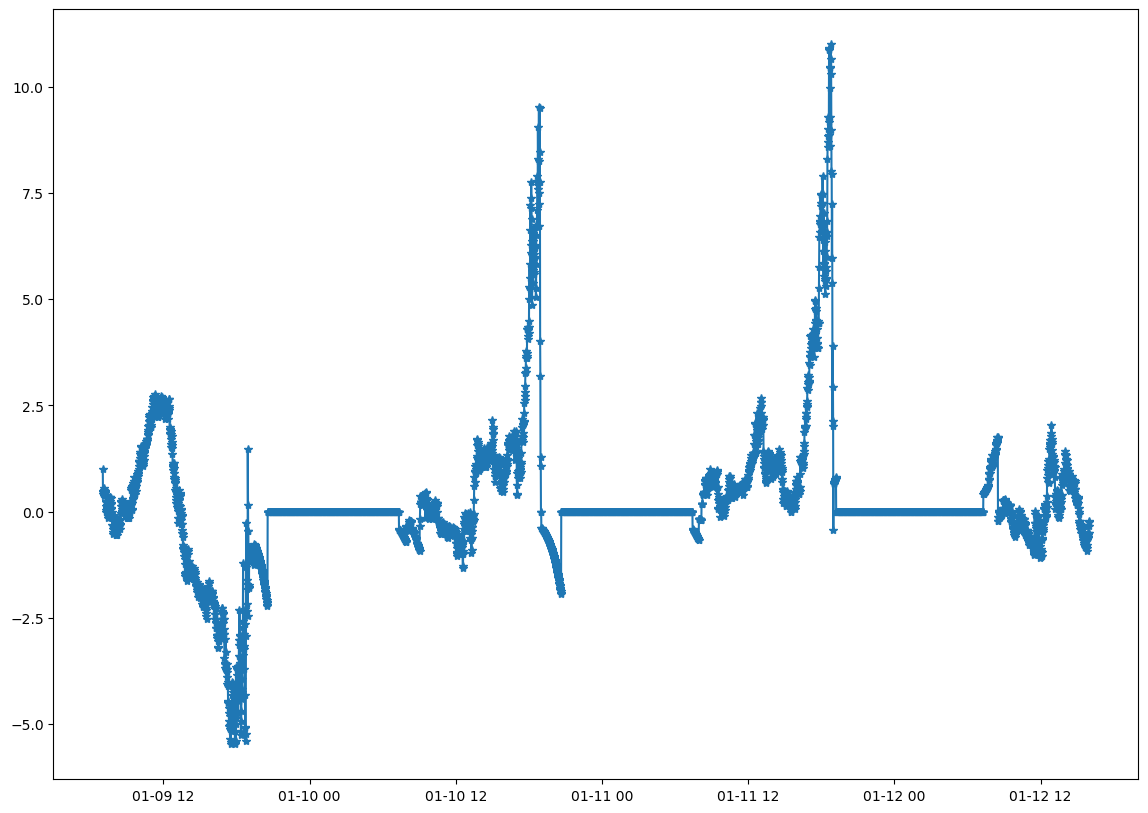

In [36]:
fig,ax=plt.subplots(figsize=(14,10))
ax.plot(feature_dataframe.index,feature_dataframe['norm_180min_return'],marker='*')

In [ ]:
# Plot the Trade_Price and the winsorized srs series on the same plot. Trying to see differnece

plt.figure(figsize=(14, 7))

# Plot original Trade_Price
plt.plot(resampled_dataframe.index, resampled_dataframe["Trade_Price"], label='Trade Price', color='blue')

# Plot winsorized srs
plt.plot(resampled_dataframe.index, resampled_dataframe["srs"], label='Winsorized SRS', color='orange')

plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Trade Price vs Winsorized SRS')
plt.legend()
plt.show()

In [37]:
# Modified function to calculate multiple MACD indicators based on arrays of window parameters

def calculate_multiple_macds(df, short_windows, long_windows, signal_windows):
    """
    Calculate multiple MACD indicators for each time step based on arrays of window sizes.

    :param df: DataFrame with high-frequency trading data and a datetime index
    :param short_windows: Array of short-term EMA window sizes
    :param long_windows: Array of long-term EMA window sizes
    :param signal_windows: Array of signal line EMA window sizes
    :return: DataFrame with multiple MACD and Signal lines
    """
    # Initialize a DataFrame to store MACD values for each set of windows
    macd_df = df.copy()
    
    # Loop through all provided window sizes
    for short_window, long_window, signal_window in zip(short_windows, long_windows, signal_windows):
        # Resample the trade prices to 1-minute intervals using the last price in the minute
        price = df['Trade_Price'].resample('1T').last().ffill()
        
        # Calculate the short-term and long-term EMAs of the trade prices
        short_ema = price.ewm(span=short_window, min_periods=1, adjust=False).mean()
        long_ema = price.ewm(span=long_window, min_periods=1, adjust=False).mean()
        
        # Calculate the MACD line and the Signal line
        macd = short_ema - long_ema
        # signal_line = macd.ewm(span=signal_window, min_periods=1, adjust=False).mean()
        
        # Store the MACD and Signal line values in the DataFrame using the window sizes as column names
        macd_df[f'MACD_{short_window}_{long_window}'] = macd
        # macd_df[f'Signal_{short_window}_{long_window}_{signal_window}'] = signal_line

    return macd_df

# Example usage:
# short_windows = [8, 16, 32]
# long_windows = [24, 28, 96]
# signal_windows = [9, 9, 9]  # Assuming the signal line uses a 9-period EMA for all
# macd_values = calculate_multiple_macds(filtered_data, short_windows, long_windows, signal_windows)


In [38]:
short_windows = [8, 16, 32]
long_windows = [24, 28, 96]
signal_windows = [9, 9, 9]  # Assuming the signal line uses a 9-period EMA for all
test_features = calculate_multiple_macds(test_features, short_windows, long_windows, signal_windows)

print(test_features.info())
print(test_features.head())



<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5040 entries, 2023-01-09 04:00:00 to 2023-01-12 15:59:00
Freq: T
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          5039 non-null   object 
 1   Symbol        5039 non-null   object 
 2   YearMonth     5039 non-null   float64
 3   Trade_Price   5040 non-null   float64
 4   Trade_Volume  5040 non-null   int64  
 5   MACD_8_24     5040 non-null   float64
 6   MACD_16_28    5040 non-null   float64
 7   MACD_32_96    5040 non-null   float64
dtypes: float64(5), int64(1), object(2)
memory usage: 354.4+ KB
None
                           Date Symbol  YearMonth  Trade_Price  Trade_Volume  \
Time                                                                           
2023-01-09 04:00:00         NaN    NaN        NaN       129.71          2053   
2023-01-09 04:01:00  2023-01-09   AAPL   202301.0       129.76          6206   
2023-01-09 04:02:00  2023-01-09

In [39]:
def calc_log_returns(df):
    # Calculate log returns
    df['Log_Returns'] = np.log(df['Trade_Price'] / df['Trade_Price'].shift(1))

calc_log_returns(test_features)

print(test_features.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5040 entries, 2023-01-09 04:00:00 to 2023-01-12 15:59:00
Freq: T
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          5039 non-null   object 
 1   Symbol        5039 non-null   object 
 2   YearMonth     5039 non-null   float64
 3   Trade_Price   5040 non-null   float64
 4   Trade_Volume  5040 non-null   int64  
 5   MACD_8_24     5040 non-null   float64
 6   MACD_16_28    5040 non-null   float64
 7   MACD_32_96    5040 non-null   float64
 8   Log_Returns   5039 non-null   float64
dtypes: float64(6), int64(1), object(2)
memory usage: 393.8+ KB
None


In [40]:
# Function to calculate volatility-normalized returns for different time intervals
def calculate_vol_normalized_returns(df, intervals):
    """
    Calculate the volatility-normalized returns for different time intervals.

    :param df: DataFrame with high-frequency trading data and a datetime index.
    :param intervals: List of intervals in minutes for which to calculate the normalized returns.
    :return: DataFrame with volatility-normalized returns for each interval.
    """
    
    # Create a DataFrame to store normalized returns for each interval
    normalized_returns_df = pd.DataFrame(index=df.index)
    
    # Loop over the intervals
    for interval in intervals:
        # Calculate the rolling standard deviation (volatility) for the current interval
        rolling_volatility = df['Log_Returns'].rolling(window=interval).std()
        
        # Volatility-normalize the log returns by dividing by the rolling volatility
        # Note that the first 'interval - 1' values will be NaN due to the rolling calculation
        normalized_returns = df['Log_Returns'] / rolling_volatility / np.sqrt(interval)
        
        # Store the normalized returns in the DataFrame
        df[f'Normalized_Returns_{interval}min'] = normalized_returns
    
    # Drop the initial rows where the rolling volatility can't be calculated
    df.dropna(inplace=True)
    
    # return normalized_returns_df

# Example intervals in minutes that might correspond to different intraday time horizons
# Since 1 minute is our smallest increment, I dont think it possible for the volatility normaled returns to be determined since std = 0
# intervals_in_minutes = [1, 60, 180, 360, 720]  # 1 minute, 1 hour, 3 hours, 6 hours, 12 hours

# Assuming 'filtered_data' has a datetime index and a 'Trade_Price' column
# Calculate the volatility-normalized returns
# vol_normalized_returns = calculate_vol_normalized_returns(filtered_data, intervals_in_minutes)
# print(vol_normalized_returns.head())

# Note: This code assumes that 'filtered_data' is already sorted by datetime and has no duplicate indices.


In [41]:
# Example intervals in minutes that might correspond to different intraday time horizons
intervals_in_minutes = [20, 60, 120, 180, 240]  # 20 minutes, 1 hour, 2 hours, 3 hours, 4 hours

# Assuming 'filtered_data' has a datetime index and a 'Trade_Price' column
# Calculate the volatility-normalized returns
calculate_vol_normalized_returns(test_features, intervals_in_minutes)
print(test_features.info())
print(test_features.head(5))

# Note: This code assumes that 'filtered_data' is already sorted by datetime and has no duplicate indices.


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2140 entries, 2023-01-09 08:00:00 to 2023-01-12 15:59:00
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Date                       2140 non-null   object 
 1   Symbol                     2140 non-null   object 
 2   YearMonth                  2140 non-null   float64
 3   Trade_Price                2140 non-null   float64
 4   Trade_Volume               2140 non-null   int64  
 5   MACD_8_24                  2140 non-null   float64
 6   MACD_16_28                 2140 non-null   float64
 7   MACD_32_96                 2140 non-null   float64
 8   Log_Returns                2140 non-null   float64
 9   Normalized_Returns_20min   2140 non-null   float64
 10  Normalized_Returns_60min   2140 non-null   float64
 11  Normalized_Returns_120min  2140 non-null   float64
 12  Normalized_Returns_180min  2140 non-null   float64
 13  Normalized_R

In [43]:
# Function to calculate draw-ups and draw-downs at different frequencies
def calculate_drawdowns_drawups(df, intervals):
    """
    Calculate draw-ups and draw-downs based on highest and lowest prices over different past intervals.

    :param df: DataFrame with high-frequency trading data and a datetime index.
    :param intervals: List of intervals in minutes for which to calculate draw-ups and draw-downs.
    :return: DataFrame with draw-ups and draw-downs for each interval.
    """
    # Calculate log prices
    df['Log_Price'] = np.log(df['Trade_Price'])
    print(df['Log_Price'].head())
    # Create a DataFrame to store drawdowns and draw-ups for each interval
    features_df = pd.DataFrame(index=df.index)

    # Loop over the intervals
    for interval in intervals:
        # Calculate the rolling max and min log prices for the current interval
        rolling_max = df['Log_Price'].rolling(window=interval).max()
        rolling_min = df['Log_Price'].rolling(window=interval).min()

        # print(rolling_max.head())
        # print(rolling_min.head())

        # Calculate drawdowns and draw-ups
        drawdowns = rolling_max - df['Log_Price']
        drawups = df['Log_Price'] - rolling_min

        # Store the drawdowns and draw-ups in the DataFrame
        df[f'Drawdowns_{interval}min'] = drawdowns
        df[f'Drawups_{interval}min'] = drawups

    # Drop the initial rows where the rolling max and min can't be calculated
    df.dropna(inplace=True)

    # return features_df

# Example intervals in minutes that might correspond to different intraday time horizons
# intervals_in_minutes = [30, 60, 180, 360, 720]  # 1 minute, 1 hour, 3 hours, 6 hours, 12 hours

# Assuming 'filtered_data' has a datetime index and a 'Trade_Price' column
# Calculate the draw-ups and draw-downs
# draw_features = calculate_drawdowns_drawups(filtered_data, intervals_in_minutes)
# print(draw_features.head())

# Note: This code assumes that 'filtered_data' is already sorted by datetime and has no duplicate indices.


In [49]:
# draw_features = calculate_drawdowns_drawups(resampled_dataframe, intervals_in_minutes)
calculate_drawdowns_drawups(test_features, intervals_in_minutes)

# Note: This code assumes that 'filtered_data' is already sorted by datetime and has no duplicate indices.


Time
2023-01-09 08:00:00    4.868764
2023-01-09 08:01:00    4.868611
2023-01-09 08:02:00    4.868611
2023-01-09 08:03:00    4.868764
2023-01-09 08:04:00    4.867996
Name: Log_Price, dtype: float64
Time
2023-01-09 08:00:00   NaN
2023-01-09 08:01:00   NaN
2023-01-09 08:02:00   NaN
2023-01-09 08:03:00   NaN
2023-01-09 08:04:00   NaN
Name: Log_Price, dtype: float64
Time
2023-01-09 08:00:00   NaN
2023-01-09 08:01:00   NaN
2023-01-09 08:02:00   NaN
2023-01-09 08:03:00   NaN
2023-01-09 08:04:00   NaN
Name: Log_Price, dtype: float64
Time
2023-01-09 08:00:00   NaN
2023-01-09 08:01:00   NaN
2023-01-09 08:02:00   NaN
2023-01-09 08:03:00   NaN
2023-01-09 08:04:00   NaN
Name: Log_Price, dtype: float64
Time
2023-01-09 08:00:00   NaN
2023-01-09 08:01:00   NaN
2023-01-09 08:02:00   NaN
2023-01-09 08:03:00   NaN
2023-01-09 08:04:00   NaN
Name: Log_Price, dtype: float64
Time
2023-01-09 08:00:00   NaN
2023-01-09 08:01:00   NaN
2023-01-09 08:02:00   NaN
2023-01-09 08:03:00   NaN
2023-01-09 08:04:00   NaN


In [50]:
test_features.describe()

,YearMonth,Trade_Price,Trade_Volume,MACD_8_24,MACD_16_28,MACD_32_96,Log_Returns,Normalized_Returns_20min,Normalized_Returns_60min,Normalized_Returns_120min,...,Drawdowns_20min,Drawups_20min,Drawdowns_60min,Drawups_60min,Drawdowns_120min,Drawups_120min,Drawdowns_180min,Drawups_180min,Drawdowns_240min,Drawups_240min
count,1901.0,1901.000000,1901.000000,1901.000000,1901.000000,1901.000000,1901.000000,1901.000000,1901.000000,1901.000000,...,1901.000000,1901.000000,1901.000000,1901.000000,1901.000000,1901.000000,1901.000000,1901.000000,1901.000000,1901.000000
mean,202301.0,131.630374,980.317728,0.000809,0.000431,0.004207,0.000002,0.003580,0.001965,0.001824,...,0.001901,0.002089,0.003660,0.004089,0.005556,0.006008,0.006900,0.007751,0.007908,0.009406
std,0.0,1.542967,1789.474791,0.135602,0.082360,0.225260,0.000866,0.224962,0.137678,0.103628,...,0.002493,0.002124,0.003808,0.003207,0.005076,0.003900,0.006071,0.004830,0.006715,0.005343
min,202301.0,128.200000,0.000000,-0.522286,-0.322418,-0.634029,-0.014851,-1.000000,-1.000000,-1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,202301.0,130.200000,100.000000,-0.065999,-0.044511,-0.122425,-0.000304,-0.096745,-0.053488,-0.036442,...,0.000226,0.000453,0.000768,0.001446,0.001224,0.002480,0.001654,0.004141,0.002407,0.005547
50%,202301.0,131.650000,600.000000,0.003281,-0.001222,0.022682,0.000000,0.000000,0.000000,0.000000,...,0.001071,0.001587,0.002541,0.003574,0.004257,0.005977,0.005122,0.007293,0.005944,0.009406
75%,202301.0,132.850000,1312.000000,0.086050,0.057463,0.179460,0.000304,0.111196,0.059679,0.040121,...,0.002488,0.002941,0.005289,0.005960,0.008778,0.009066,0.011942,0.011698,0.013762,0.013395
max,202301.0,134.549000,50078.000000,0.419278,0.192657,0.483947,0.005635,1.000000,1.000000,1.000000,...,0.015642,0.013122,0.021174,0.016101,0.023055,0.016520,0.023055,0.021438,0.024272,0.022745
